# Note: in the  cell below we got data leakage

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
df=pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
df = df.drop(columns=['Unnamed: 0'])
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
selector_model = RandomForestClassifier(random_state=42)
selector = SelectFromModel(selector_model, threshold='mean')
selector.fit(X_resampled, y_resampled)
X_resampled_sel = selector.transform(X_resampled)
X_test_sel = selector.transform(X_test)
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_resampled_sel, y_resampled)
y_pred = model.predict(X_test_sel)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

 Accuracy: 0.78125
              precision    recall  f1-score   support

    NonToxic       0.86      0.82      0.84        22
       Toxic       0.64      0.70      0.67        10

    accuracy                           0.78        32
   macro avg       0.75      0.76      0.75        32
weighted avg       0.79      0.78      0.78        32



# In the below cells i tried to explore the data ditribution

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
print(df['Class'].value_counts())


Class
NonToxic    108
Toxic        51
Name: count, dtype: int64


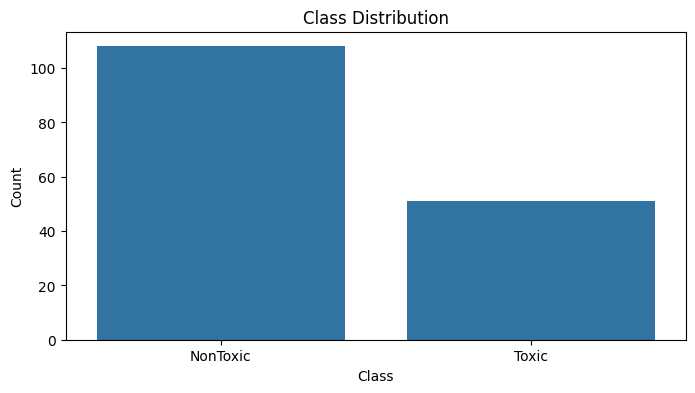

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("before resampling training set shape without SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled training set shape with SMOTE:", Counter(y_train_res))


before resampling training set shape without SMOTE: Counter({0: 86, 1: 41})
Resampled training set shape with SMOTE: Counter({0: 86, 1: 86})


# In the cell below we slpitted the data then we did PCA to avoid data leakage then we trained random forest classifier

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

df = pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


print(f"Shape after PCA - Training: {X_train_pca.shape}, Test: {X_test_pca.shape}")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model using the PCA-transformed data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_pca, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


Shape after PCA - Training: (127, 85), Test: (32, 85)
Model Accuracy: 0.6875


# In the below cells we tried different combinations from using feature slection and feature extraction. Like we used PCA and RFE , PCA and TSNE

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


df = pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
X = df.drop('Class', axis=1)
y = df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Shape after PCA - Training: {X_train_pca.shape}, Test: {X_test_pca.shape}")


base_model = XGBClassifier(eval_metric='logloss', random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=30, step=1)
rfe.fit(X_train_pca, y_train)


X_train_rfe = rfe.transform(X_train_pca)
X_test_rfe = rfe.transform(X_test_pca)
print(f"Shape after RFE - Training: {X_train_rfe.shape}, Test: {X_test_rfe.shape}")

final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_train_rfe, y_train)

y_pred = final_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy with PCA + RFE + XGB:", accuracy)


Shape after PCA - Training: (127, 85), Test: (32, 85)
Shape after RFE - Training: (127, 30), Test: (32, 30)
Final Accuracy with PCA + RFE + XGB: 0.6875


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
X = df.drop('Class', axis=1)
y = df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA - Training shape: {X_train_pca.shape}, Test shape: {X_test_pca.shape}")

X_pca_all = np.concatenate([X_train_pca, X_test_pca], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

tsne = TSNE(n_components=2, random_state=42)
X_tsne_all = tsne.fit_transform(X_pca_all)
print(f"t-SNE output shape: {X_tsne_all.shape}")


X_train_tsne = X_tsne_all[:len(X_train_pca)]
X_test_tsne = X_tsne_all[len(X_train_pca):]
print(f"t-SNE - Training shape: {X_train_tsne.shape}, Test shape: {X_test_tsne.shape}")

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_tsne, y_train)

y_pred = model.predict(X_test_tsne)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with PCA + t-SNE + XGB:", accuracy)


PCA - Training shape: (127, 85), Test shape: (32, 85)
t-SNE output shape: (159, 2)
t-SNE - Training shape: (127, 2), Test shape: (32, 2)
Accuracy with PCA + t-SNE + XGB: 0.71875


## In the below cell i tried to use only RFE but pick top 50 features

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')

df = df.loc[:, df.nunique() > 1]
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

estimator = XGBClassifier(eval_metric='logloss', random_state=42)

n_features_to_select = 50
rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train, y_train)

selected_feature_mask = rfe.get_support()
selected_features = X.columns[selected_feature_mask]
print("Selected features:", selected_features.tolist())
print("Number of features selected:", sum(selected_feature_mask))

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_train_rfe, y_train)

y_pred = final_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print("Final accuracy with RFE-selected features:", accuracy)


Selected features: ['MATS3p', 'MATS3e', 'MATS3m', 'VR3_Dt', 'SpMax3_Bhv', 'SpMax3_Bhp', 'MAXDN', 'ATSC8i', 'SpAD_Dt', 'XLogP', 'R_TpiPCTPC', 'MATS1s', 'ETA_Eta_F_L', 'AATS7e', 'ETA_Epsilon_4', 'ETA_BetaP_s', 'ATS1m', 'SRW10', 'AATS6p', 'SpMin8_Bhi', 'ATSC3v', 'SpMax7_Bhe', 'SpMax7_Bhs', 'MIC2', 'SHaaCH', 'ATSC1v', 'MWC6', 'SHBa', 'AATSC8i', 'GATS5i', 'IC5', 'GATS4e', 'ATSC7p', 'ATSC7c', 'JGI7', 'JGI8', 'GATS7c', 'GATS7s', 'SpMin1_Bhi', 'SpMin1_Bhp', 'MLFER_S', 'ATS3v', 'ATS0m', 'minHother', 'VR1_DzZ', 'GATS8m', 'SpMax2_Bhs', 'SpMAD_Dt', 'VE2_Dzi', 'SpMax5_Bhm']
Number of features selected: 50
Final accuracy with RFE-selected features: 0.5625


# In the approach i used grid search and i tried partition overall number of feature to select where we got 71 accuray

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/Molecules_Toxicity_Classification.csv')
df = df.loc[:, df.nunique() > 1]
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}

for n_features in range(2, 21):
    dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    rfe = RFE(estimator=dtc, n_features_to_select=n_features, step=1)
    X_rfe = rfe.fit_transform(X_scaled, y_encoded)
    scores = cross_val_score(dtc, X_rfe, y_encoded, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    results[n_features] = mean_score
    print(f"Feature Cardinality: {n_features}, Mean CV Accuracy: {mean_score:.4f}")

best_n_features = max(results, key=results.get)
print(f"\nBest feature set size (cardinality): {best_n_features} with Mean CV Accuracy: {results[best_n_features]:.4f}")

rfe_best = RFE(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
               n_features_to_select=best_n_features, step=1)
rfe_best.fit(X_scaled, y_encoded)
selected_features = X.columns[rfe_best.get_support()].tolist()
print("Selected features at best cardinality:", selected_features)

current_features = selected_features.copy()
current_accuracy = results[best_n_features]
print("\nStarting iterative pruning. Baseline CV Accuracy:", current_accuracy)
improvement = True

while improvement and len(current_features) > 1:
    improvement = False
    candidate_results = {}
    for feature in current_features:
        candidate_features = [f for f in current_features if f != feature]
        X_candidate = X[candidate_features]
        X_candidate_scaled = scaler.fit_transform(X_candidate)
        dtc_candidate = DecisionTreeClassifier(class_weight='balanced', random_state=42)
        scores_candidate = cross_val_score(dtc_candidate, X_candidate_scaled, y_encoded, cv=cv, scoring='accuracy')
        candidate_accuracy = np.mean(scores_candidate)
        candidate_results[feature] = candidate_accuracy
    best_removal_feature = max(candidate_results, key=candidate_results.get)
    best_candidate_accuracy = candidate_results[best_removal_feature]
    if best_candidate_accuracy > current_accuracy:
        print(f"Removing '{best_removal_feature}' improved accuracy from {current_accuracy:.4f} to {best_candidate_accuracy:.4f}")
        current_features.remove(best_removal_feature)
        current_accuracy = best_candidate_accuracy
        improvement = True
    else:
        print("No removal improved the accuracy further.")
        break

print("\nFinal selected feature set after iterative pruning:", current_features)
print("Final CV Accuracy:", current_accuracy)

X_final = X[current_features]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

param_grid = {
    'max_depth': list(range(1, 11)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': list(range(1, len(current_features)+1))
}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42),
                           param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_final_scaled, y_train_final)
print("\nBest hyperparameters from Grid Search:")
print(grid_search.best_params_)
print("Best CV Accuracy from Grid Search:", grid_search.best_score_)

final_model = grid_search.best_estimator_
final_model.fit(X_train_final_scaled, y_train_final)

y_pred_final = final_model.predict(X_test_final_scaled)
final_accuracy = np.mean(y_pred_final == y_test_final)
print("\nFinal hold-out test accuracy:", final_accuracy)


Feature Cardinality: 2, Mean CV Accuracy: 0.6854
Feature Cardinality: 3, Mean CV Accuracy: 0.6471
Feature Cardinality: 4, Mean CV Accuracy: 0.6417
Feature Cardinality: 5, Mean CV Accuracy: 0.6600
Feature Cardinality: 6, Mean CV Accuracy: 0.6479
Feature Cardinality: 7, Mean CV Accuracy: 0.7175
Feature Cardinality: 8, Mean CV Accuracy: 0.7175
Feature Cardinality: 9, Mean CV Accuracy: 0.7046
Feature Cardinality: 10, Mean CV Accuracy: 0.7421
Feature Cardinality: 11, Mean CV Accuracy: 0.7804
Feature Cardinality: 12, Mean CV Accuracy: 0.8171
Feature Cardinality: 13, Mean CV Accuracy: 0.7662
Feature Cardinality: 14, Mean CV Accuracy: 0.7787
Feature Cardinality: 15, Mean CV Accuracy: 0.7850
Feature Cardinality: 16, Mean CV Accuracy: 0.8100
Feature Cardinality: 17, Mean CV Accuracy: 0.7725
Feature Cardinality: 18, Mean CV Accuracy: 0.7787
Feature Cardinality: 19, Mean CV Accuracy: 0.7913
Feature Cardinality: 20, Mean CV Accuracy: 0.7850

Best feature set size (cardinality): 12 with Mean CV Accu